# Ensembles Historical Variables from LOCA and BCSD

This notebook analyzes meteorologic and hydrologic variables from the historical scenario (1950-2005) from the LOCA and BCSD datasets. 

Variables include:
- Precipitation
- Temperature
- ET
- Total Runoff
- SWE

In [10]:
from loca import print_date
print_date()

Last executed: 2019-10-02 16:37:09.274274 by jvano on casper03


# Imports and Options

In [11]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt
import cmocean

import xarray as xr

from loca.data_catalog import load_monthly_historical_met_datasets, load_daily_livneh_meteorology, resample_monthly_data
from loca.utils import calc_change
from loca.plot import make_plot, PROJECTION, add_ylabel

from cmocean import cm

# list of 23:
models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m',
          'CESM1-BGC', 'CMCC-CM', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR',
          'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G', 
          'CNRM-CM5', 'CSIRO-Mk3-6-0', 'GFDL-ESM2M','GFDL-CM3', 'HadGEM2-AO']

# models = ['ACCESS1-0', 'CanESM2']

#cache is written in script "write_cache.ipynb"  TODO
read_cache = True
# cache_dir = os.environ['TMPDIR']
cache_dir = '/glade/u/home/jvano/scratch/'

all_vars = ['pcp', 't_mean', 't_min', 't_max', 'ET', 'total_runoff']
met_vars = ['pcp', 't_mean']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.join(os.environ['HOME'], 'scheduler_file.json'))
client

Client Scheduler: tcp://128.117.181.209:37753 Dashboard: proxy/8787/status,Cluster Workers: 2 Cores: 4 Memory: 60.00 GB


# Load Data

In [13]:
hist_epoch = slice('1970-01-01', '1999-12-31') 
futr_epoch = slice('2070-01-01', '2099-12-31')

In [14]:
# Read met data

read_cache = True
hist_data_met = {}
rcp4_data_met = {}
rcp8_data_met = {}
if read_cache:
    for key in ['loca', 'bcsd']:
        hist_data_met[key] = xr.open_mfdataset(
            os.path.join(cache_dir, f'monthly_cmip_met_hist.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})    
        rcp4_data_met[key] = xr.open_mfdataset(
            os.path.join(cache_dir, f'monthly_cmip_met_rcp4.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
        rcp8_data_met[key] = xr.open_mfdataset(
            os.path.join(cache_dir, f'monthly_cmip_met_rcp8.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})

In [15]:
# mask area and do time slices for met

mask = hist_data_met['bcsd']['t_mean'].isel(gcm=0, time=0).squeeze().notnull()

# TODO: these means should be weighted by days per month
hist_met_means = dict((k, resample_monthly_data(ds.sel(time=hist_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in hist_data_met.items())
rcp4_met_means = dict((k, resample_monthly_data(ds.sel(time=futr_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in rcp4_data_met.items())
rcp8_met_means = dict((k, resample_monthly_data(ds.sel(time=futr_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in rcp8_data_met.items())

In [16]:
# Read hydro data

read_cache = True
hist_data_hydro = {}
rcp4_data_hydro = {}
rcp8_data_hydro = {}
if read_cache:
    for key in ['loca', 'bcsd']:
        hist_data_hydro[key] = xr.open_mfdataset(
            os.path.join(cache_dir, f'monthly_cmip_hydro_hist.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
        rcp4_data_hydro[key] = xr.open_mfdataset(
            os.path.join(cache_dir, f'monthly_cmip_hydro_rcp4.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
        rcp8_data_hydro[key] = xr.open_mfdataset(
            os.path.join(cache_dir, f'monthly_cmip_hydro_rcp8.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})

In [17]:
# do time slices for hydro

hist_hydro_means = dict((k, resample_monthly_data(ds.sel(time=hist_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in hist_data_hydro.items())
rcp4_hydro_means = dict((k, resample_monthly_data(ds.sel(time=futr_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in rcp4_data_hydro.items())
rcp8_hydro_means = dict((k, resample_monthly_data(ds.sel(time=futr_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in rcp8_data_hydro.items())

# Plots

A single plot of both met and hydro data

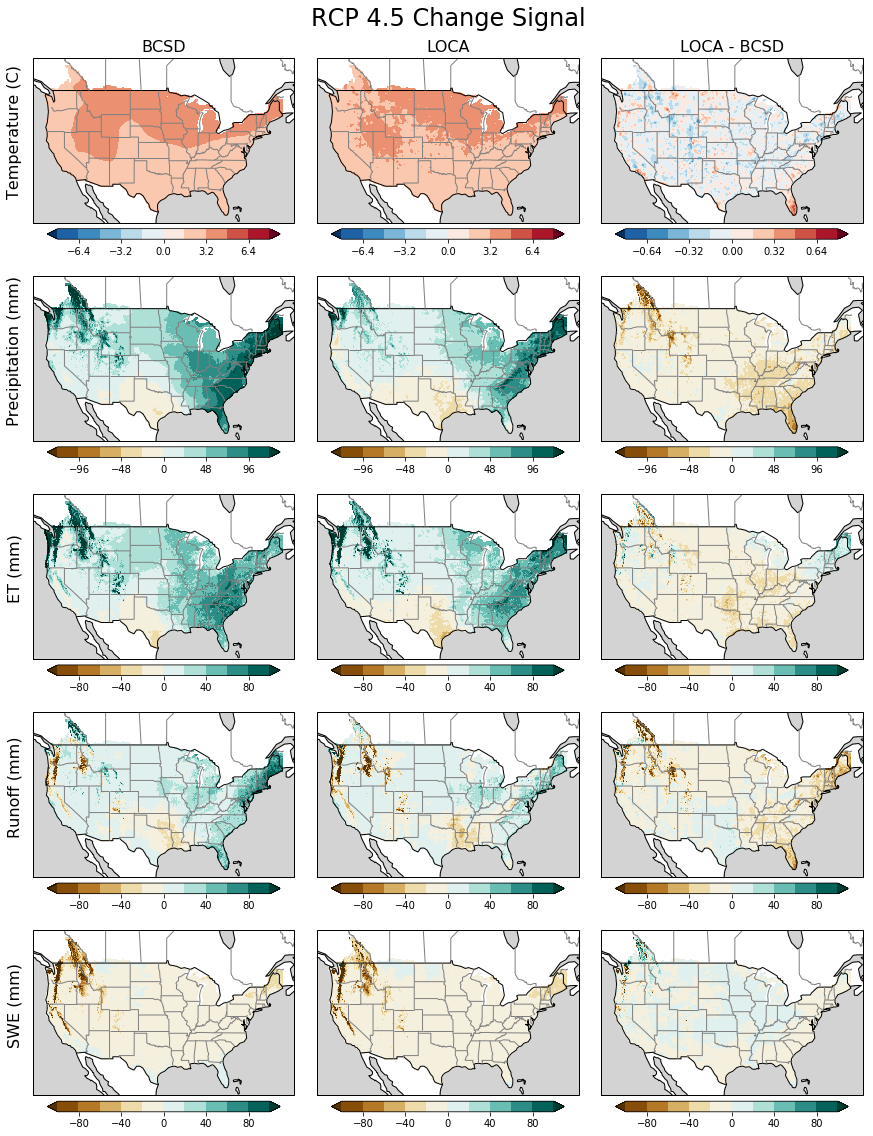

In [19]:
# FIG 2,3

rcp = 'rcp4'  #rcp4 or rcp8
rcpname = {'rcp4': 'RCP 4.5', 'rcp8': 'RCP 8.5'}

style_kwargs =  {'levels': 11, 'add_labels': False, 'extend': 'both', 'cbar_kwargs': dict(orientation="horizontal", shrink=0.85, pad=0.03)}
kwargs = {'ET': {'vmin': 0, 'vmax': 1000, **style_kwargs},
          'total_runoff': {'vmin': 0, 'vmax': 1000, **style_kwargs}, 
          'SWE': {'vmin': 0, 'vmax': 100, **style_kwargs},}

# units = {'ET': 'mm', 'total_runoff': 'mm', 'SWE': 'mm'}
variablename = {'total_runoff':'Runoff (mm)', 'ET': 'ET (mm)', 'SWE': 'SWE (mm)',  't_mean': 'Temperature (C)', 'pcp': 'Precipitation (mm)'}

watercmap = cm.rain  #https://matplotlib.org/cmocean/
watercmapdiff = 'BrBG'
tempcmapdiff = 'RdBu_r'


cache = {}

# subcols = [('Historical', hist_hydro_means), ('RCP 4.5', rcp4_hydro_means)] 

met_vars = ['t_mean', 'pcp']
hydro_vars = ['ET', 'total_runoff', 'SWE']

nrows = len(met_vars) + len(hydro_vars)
all_vars = met_vars + hydro_vars

diff_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': watercmapdiff, **style_kwargs},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': watercmapdiff, **style_kwargs},
                   'SWE': {'vmin': -100, 'vmax': 100, 'cmap': watercmapdiff, **style_kwargs},
                   'pcp': {'vmin': -25, 'vmax': 25, 'cmap': watercmapdiff, **style_kwargs}}, 
            False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': watercmapdiff, **style_kwargs},
                   'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': watercmapdiff, **style_kwargs},
                   'SWE': {'vmin': -100, 'vmax': 100, 'cmap': watercmapdiff, **style_kwargs},
                   'pcp': {'vmin': -120, 'vmax': 120, 'cmap': watercmapdiff, **style_kwargs},
                    't_mean': {'vmin': -8, 'vmax': 8, 'cmap': tempcmapdiff,**style_kwargs}}}

diff2_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': watercmapdiff, **style_kwargs},
                    'total_runoff': {'vmin': -25, 'vmax': 25, 'cmap': watercmapdiff, **style_kwargs},
                    'SWE': {'vmin': -50, 'vmax': 50, 'cmap': watercmapdiff,  **style_kwargs},
                    'pcp': {'vmin': -15, 'vmax': 15, 'cmap': watercmapdiff, **style_kwargs}}, 
             False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': watercmapdiff,  **style_kwargs},
                     'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': watercmapdiff, **style_kwargs},
                     'SWE': {'vmin': -100, 'vmax': 100, 'cmap': watercmapdiff, **style_kwargs},
                     'pcp': {'vmin': -120, 'vmax': 120, 'cmap': watercmapdiff, **style_kwargs}, 
                     't_mean': {'vmin': -0.8, 'vmax': 0.8, 'cmap': tempcmapdiff, **style_kwargs}}} 


fig, axes = plt.subplots(ncols=3, nrows=nrows, figsize=(12, 3.1*nrows), subplot_kw={'projection': PROJECTION})

for pct in [False]:
    for row, var in enumerate(all_vars):
        for col, dset in enumerate(['bcsd', 'loca']):
            ax = axes[row, col]
            if var in met_vars:
                rcpfilename =  {'rcp4': rcp4_met_means, 'rcp8':  rcp8_met_means}
                ens_change = calc_change(hist_met_means[dset][var].mean('gcm'), rcpfilename[rcp][dset][var].mean('gcm'), pct=pct)
            elif var in hydro_vars:
                rcpfilename =  {'rcp4': rcp4_hydro_means, 'rcp8':  rcp8_hydro_means}
                ens_change = calc_change(hist_hydro_means[dset][var].mean('gcm'), rcpfilename[rcp][dset][var].mean('gcm'), pct=pct)
            else:
                raise ValueError('%s not in met or hydro vars' % var)
            make_plot(ens_change, ax=ax, plot_kwargs=diff_kws[pct][var])
            cache[(row, col)] = ens_change.persist()                 

            if row == 0:
                ax.set_title(dset.upper(), fontsize=16)
            if col == 0:
                add_ylabel(ax, variablename[var], fontsize=16)

        diff = cache[(row, col)] - cache[(row, col - 1)]
        make_plot(diff, ax=axes[row, col + 1], plot_kwargs=diff2_kws[pct][var]) 
        axes[0, -1].set_title('LOCA - BCSD', fontsize=16)

        if pct:
            unit_str = '%'
        else:
            unit_str = 'mm'
        
    title = rcpname[rcp] + " Change Signal"
    fig.suptitle(title, fontsize=24, y=1.02)
    fig.tight_layout()
    fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/change_signal_{rcp}_mon_fut.png', dpi=300, bbox_inches='tight')

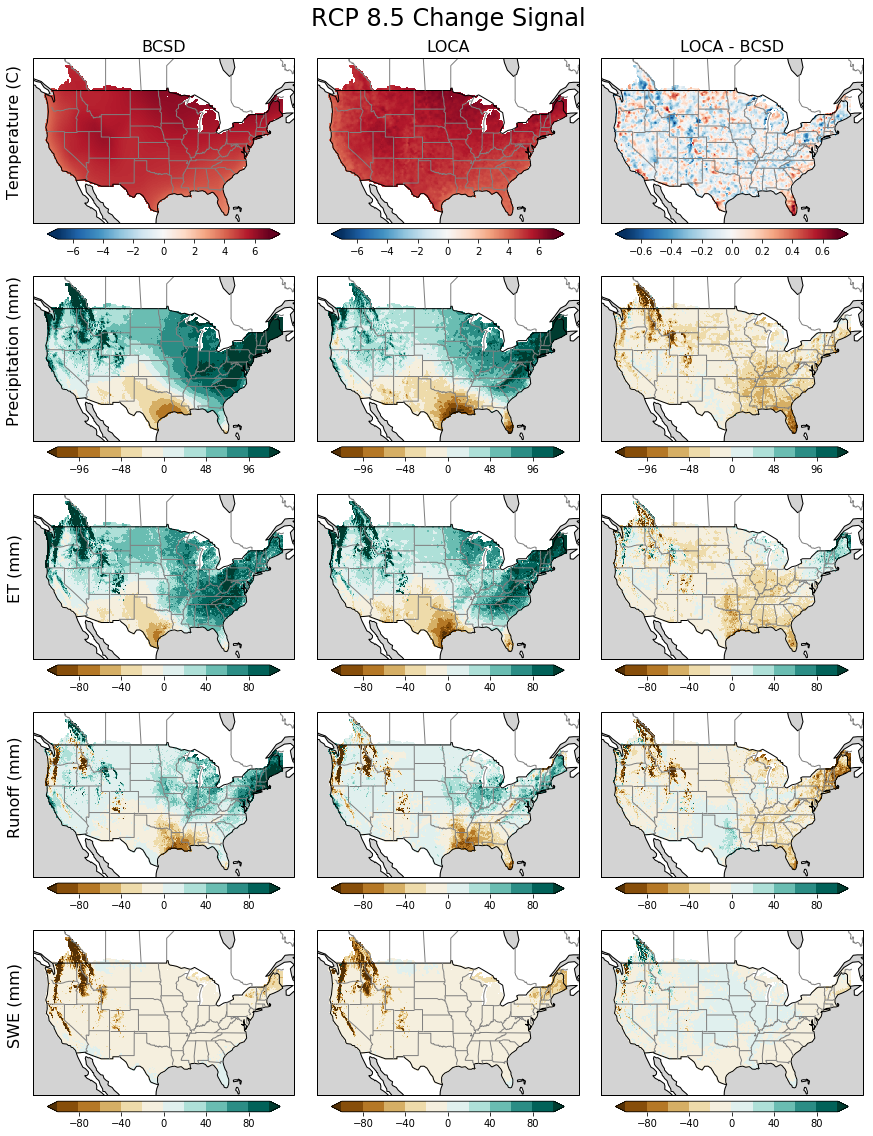

In [22]:
# FIG 2,3, REVISED TEMP

rcp = 'rcp8'  #rcp4 or rcp8
rcpname = {'rcp4': 'RCP 4.5', 'rcp8': 'RCP 8.5'}

style_kwargs =  {'add_labels': False, 'extend': 'both', 'cbar_kwargs': dict(orientation="horizontal", shrink=0.85, pad=0.03)}
kwargs = {'ET': {'levels': 11, 'vmin': 0, 'vmax': 1000, **style_kwargs},
          'total_runoff': {'levels': 11, 'vmin': 0, 'vmax': 1000, **style_kwargs}, 
          'SWE': {'levels': 11, 'vmin': 0, 'vmax': 100, **style_kwargs},}

# units = {'ET': 'mm', 'total_runoff': 'mm', 'SWE': 'mm'}
variablename = {'total_runoff':'Runoff (mm)', 'ET': 'ET (mm)', 'SWE': 'SWE (mm)',  't_mean': 'Temperature (C)', 'pcp': 'Precipitation (mm)'}

watercmap = cm.rain  #https://matplotlib.org/cmocean/
watercmapdiff = 'BrBG'
tempcmapdiff = 'RdBu_r'


cache = {}

# subcols = [('Historical', hist_hydro_means), ('RCP 4.5', rcp4_hydro_means)] 

met_vars = ['t_mean', 'pcp']
hydro_vars = ['ET', 'total_runoff', 'SWE']

nrows = len(met_vars) + len(hydro_vars)
all_vars = met_vars + hydro_vars

diff_kws = {True: {'ET': {'levels': 11, 'vmin': -25, 'vmax': 25, 'cmap': watercmapdiff, **style_kwargs},
                   'total_runoff': {'levels': 11, 'vmin': -50, 'vmax': 50, 'cmap': watercmapdiff, **style_kwargs},
                   'SWE': {'levels': 11, 'vmin': -100, 'vmax': 100, 'cmap': watercmapdiff, **style_kwargs},
                   'pcp': {'levels': 11, 'vmin': -25, 'vmax': 25, 'cmap': watercmapdiff, **style_kwargs}}, 
            False: {'ET': {'levels': 11, 'vmin': -100, 'vmax': 100, 'cmap': watercmapdiff, **style_kwargs},
                   'total_runoff': {'levels': 11, 'vmin': -100, 'vmax': 100, 'cmap': watercmapdiff, **style_kwargs},
                   'SWE': {'levels': 11, 'vmin': -100, 'vmax': 100, 'cmap': watercmapdiff, **style_kwargs},
                   'pcp': {'levels': 11, 'vmin': -120, 'vmax': 120, 'cmap': watercmapdiff, **style_kwargs},
                    't_mean': {'vmin': -7, 'vmax': 7, 'cmap': tempcmapdiff,**style_kwargs}}}

diff2_kws = {True: {'ET': {'levels': 11, 'vmin': -25, 'vmax': 25, 'cmap': watercmapdiff, **style_kwargs},
                    'total_runoff': {'levels': 11, 'vmin': -25, 'vmax': 25, 'cmap': watercmapdiff, **style_kwargs},
                    'SWE': {'levels': 11, 'vmin': -50, 'vmax': 50, 'cmap': watercmapdiff,  **style_kwargs},
                    'pcp': {'levels': 11, 'vmin': -15, 'vmax': 15, 'cmap': watercmapdiff, **style_kwargs}}, 
             False: {'ET': {'levels': 11, 'vmin': -100, 'vmax': 100, 'cmap': watercmapdiff,  **style_kwargs},
                     'total_runoff': {'levels': 11, 'vmin': -100, 'vmax': 100, 'cmap': watercmapdiff, **style_kwargs},
                     'SWE': {'levels': 11, 'vmin': -100, 'vmax': 100, 'cmap': watercmapdiff, **style_kwargs},
                     'pcp': {'levels': 11, 'vmin': -120, 'vmax': 120, 'cmap': watercmapdiff, **style_kwargs}, 
                     't_mean': {'vmin': -0.7, 'vmax': 0.7, 'cmap': tempcmapdiff, **style_kwargs}}} 


fig, axes = plt.subplots(ncols=3, nrows=nrows, figsize=(12, 3.1*nrows), subplot_kw={'projection': PROJECTION})

for pct in [False]:
    for row, var in enumerate(all_vars):
        for col, dset in enumerate(['bcsd', 'loca']):
            ax = axes[row, col]
            if var in met_vars:
                rcpfilename =  {'rcp4': rcp4_met_means, 'rcp8':  rcp8_met_means}
                ens_change = calc_change(hist_met_means[dset][var].mean('gcm'), rcpfilename[rcp][dset][var].mean('gcm'), pct=pct)
            elif var in hydro_vars:
                rcpfilename =  {'rcp4': rcp4_hydro_means, 'rcp8':  rcp8_hydro_means}
                ens_change = calc_change(hist_hydro_means[dset][var].mean('gcm'), rcpfilename[rcp][dset][var].mean('gcm'), pct=pct)
            else:
                raise ValueError('%s not in met or hydro vars' % var)
            make_plot(ens_change, ax=ax, plot_kwargs=diff_kws[pct][var])
            cache[(row, col)] = ens_change.persist()                 

            if row == 0:
                ax.set_title(dset.upper(), fontsize=16)
            if col == 0:
                add_ylabel(ax, variablename[var], fontsize=16)

        diff = cache[(row, col)] - cache[(row, col - 1)]
        make_plot(diff, ax=axes[row, col + 1], plot_kwargs=diff2_kws[pct][var]) 
        axes[0, -1].set_title('LOCA - BCSD', fontsize=16)

        if pct:
            unit_str = '%'
        else:
            unit_str = 'mm'
        
    title = rcpname[rcp] + " Change Signal"
    fig.suptitle(title, fontsize=24, y=1.02)
    fig.tight_layout()
    fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/change_signal_{rcp}_mon_fut.png', dpi=300, bbox_inches='tight')

In [ ]:
# cleanup 
plt.close('all')